## Ensemble Learning

In [7]:
#Probability mass function

from scipy.special import comb
import math

def ensemble_error(n_classifier, error):
    k_start = int(math.ceil(n_classifier / 2.))
    probs = [comb(n_classifier, k) * error **k 
             * (1-error)** (n_classifier - k)
             for k in range(k_start, n_classifier + 1)]
    return sum(probs)

In [8]:
ensemble_error(n_classifier=11, error=0.25)

0.03432750701904297

In [9]:
# computer ensemble error rate for different errors
import numpy as np
import matplotlib.pyplot as plt

error_range = np.arange(0.0, 1.01, 0.01)
ens_error = [ensemble_error(n_classifier=11, error=error) for error in error_range]

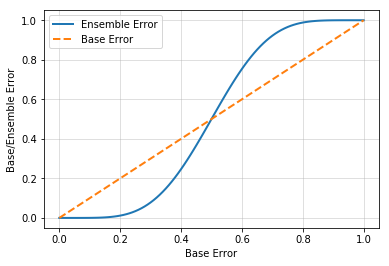

In [10]:
plt.plot(error_range, ens_error, label='Ensemble Error', linewidth=2)
plt.plot(error_range, error_range, linestyle='--', label='Base Error', linewidth=2)
plt.xlabel('Base Error')
plt.ylabel('Base/Ensemble Error')
plt.legend(loc='upper left')
plt.grid(alpha=0.5)
plt.show()

### Majority Vote Classification 

In [11]:
from sklearn.base import BaseEstimator, ClassifierMixin, clone
from sklearn.preprocessing import LabelEncoder
from sklearn.externals import six
from sklearn.pipeline import _name_estimators
import numpy as np
import operator

In [12]:
class MajorityVoteClassifier(BaseEstimator, ClassifierMixin):
    
    def __init__(self, classifier, vote='classlabel', weights=None):
        self.classifier = classifier
        self.named_classifier = {key: value for key,value in _name_estimators(classifier)}
        self.vote = vote
        self.weights = weights
    
    def fit(self, X, y):
        self.labelenc = LabelEncoder()
        self.labelenc.fit(y)
        self.classes = self.labelenc.classes
        self.classifiers = []
        for clf in self.classifiers:
            fitted_clf = clone(clf).fit(X, self.labelenc.transform(y))
            self.classifiers.append(fitted_clf)
        return self
    
    def predict(self, X):
        if self.vote == 'probability':
            maj_vote = np.argmax(self.predict_proba(X), axis=1)
        else:
            predications = np.asarray([clf.predict(X) for clf in self.classifiers]).T
            
            maj_vote = np.apply_along_axis(lambda x: np.argmax(np.bincount(x, weights=self.weights)),axis=1, arr=predications)
        
        maj_vote = self.lablenc_.inverse_transform(maj_vote)
        return maj_vote
    
    def predict_proba(self, X):
        probas = np.asarray([clf.predict_proba(X) for clf in self.classifiers])
        
        avg_probas = np.average(probas, axis=1, weights=self.weights)
        
        return avg_probas
    
    def get_params(self, deep=True):
        if not deep :
            return super(MajorityVoteClassifier,self).get_params(deep=False)
        
        else:
            out = self.named_classifiers.copy()
            for name, step in six.iteritems(self.named_classifiers):
                for key, value in six.iteritems(step.get_params(deep=True)):
                    out['%s__%s' % (name, key)] = value
            return out
            

In [13]:
from sklearn import datasets
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split

In [14]:
iris = datasets.load_iris()
X,y = iris.data[50:, [1,2]], iris.target[50:]
le = LabelEncoder()
y = le.fit_transform(y)

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=1, stratify=y)

In [16]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
import numpy as np

In [18]:
clf1 = LogisticRegression(penalty='l2',
                          C=0.001,
                          random_state=1)

clf2 = DecisionTreeClassifier(max_depth=1,
                              criterion='entropy',
                              random_state=0)

clf3 = KNeighborsClassifier(n_neighbors=1,
                            p=2,
                            metric='minkowski')

pipe1 = Pipeline([['sc', StandardScaler()],
                  ['clf', clf1]])

pipe3 = Pipeline([['sc', StandardScaler()],
                  ['clf', clf3]])

clf_label = ['Logistic Regression', 'Decision Tree', 'KNN']
print('10 fold cross-validation:\n')

for clf, label in zip([pipe1,clf3, pipe3], clf_label):
    scores = cross_val_score(estimator=clf,
                             X= X_train,
                             y = y_train,
                             cv=10,
                             scoring='roc_auc')
    print('ROC AUC: %0.2f (+/- %0.2f) [%s]' % (scores.mean(), scores.std(), label))

10 fold cross-validation:

ROC AUC: 0.87 (+/- 0.17) [Logistic Regression]
ROC AUC: 0.86 (+/- 0.14) [Decision Tree]
ROC AUC: 0.88 (+/- 0.15) [KNN]


In [21]:
mv_clf = MajorityVoteClassifier(classifier=[pipe1, clf3, pipe3])
clf_label += ['Majority voting']
all_clf = [pipe1, clf2, pipe3, mv_clf]
for clf,label in zip(all_clf, clf_label):
    scores = cross_val_score(estimator=clf,
                             X= X_train,
                             y= y_train,
                             cv=10,
                             scoring='roc_auc')
    print('ROC AUC: %0.2f (+/- %0.2f) [%s]' % (scores.mean(), scores.std(), label))

ROC AUC: 0.87 (+/- 0.17) [Logistic Regression]
ROC AUC: 0.89 (+/- 0.16) [Decision Tree]
ROC AUC: 0.88 (+/- 0.15) [KNN]


AttributeError: 'LabelEncoder' object has no attribute 'classes'

## Bagging

In [2]:
import pandas as pd

df_wine = pd.read_csv('https://archive.ics.uci.edu/ml/'
                      'machine-learning-databases/wine/wine.data',
                      header=None)

df_wine.columns = ['Class label', 'Alcohol', 'Malic acid', 'Ash',
                   'Alcalinity of ash', 'Magnesium', 'Total phenols',
                   'Flavanoids', 'Nonflavanoid phenols', 'Proanthocyanins',
                   'Color intensity', 'Hue', 'OD280/OD315 of diluted wines',
                   'Proline']

# drop 1 class
df_wine = df_wine[df_wine['Class label'] != 1]

y = df_wine['Class label'].values
X = df_wine[['Alcohol', 'Hue']].values

In [3]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

le = LabelEncoder()
y = le.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1, stratify=y)

In [4]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier

tree = DecisionTreeClassifier(criterion='entropy',
                              random_state=1,
                              max_depth=None)

bag = BaggingClassifier(base_estimator=tree,
                        n_estimators=500,
                        max_samples=1.0,
                        max_features=1.0,
                        bootstrap=True,
                        bootstrap_features=False,
                        n_jobs=1,
                        random_state=1
                        )

In [6]:
from sklearn.metrics import accuracy_score

tree = tree.fit(X_train, y_train)
y_train_pred = tree.predict(X_train)
y_test_pred = tree.predict(X_test)

tree_train = accuracy_score(y_train, y_train_pred)
tree_test = accuracy_score(y_test, y_test_pred)

print('Decision Tree train/test accuracy: %.3f/%.3f' %(tree_train, tree_test))

Decision Tree train/test accuracy: 1.000/0.917


In [7]:
bag = bag.fit(X_train, y_train)
y_train_pred = bag.predict(X_train)
y_test_pred = bag.predict(X_test)
tree_train = accuracy_score(y_train, y_train_pred)
test_train = accuracy_score(y_test, y_test_pred)

print('Decision Tree train/test accuracy: %.3f/%.3f' %(tree_train, tree_test))

Decision Tree train/test accuracy: 1.000/0.917


## AdaBoost

In [10]:
from sklearn.ensemble import AdaBoostClassifier

tree = DecisionTreeClassifier(criterion='entropy',
                              random_state=1,
                              max_depth=1)

ada = AdaBoostClassifier(base_estimator=tree,
                         n_estimators=500,
                         learning_rate=0.1,
                         random_state=1)

In [14]:
tree = tree.fit(X_train, y_train)
y_train_pred = tree.predict(X_train)
y_test_pred = tree.predict(X_test)
tree_train = accuracy_score(y_train, y_train_pred)
test_test = accuracy_score(y_test, y_test_pred)

print('Decision Tree train/test accuracy: %.3f/%.3f' %(tree_train, tree_test))

Decision Tree train/test accuracy: 0.905/0.917


In [15]:
ada = ada.fit(X_train, y_train)
y_tree_pred = ada.predict(X_train)
y_test_pred = ada.predict(X_test)
ada_train = accuracy_score(y_train, y_train_pred)
ada_test = accuracy_score(y_test, y_test_pred)

print('Decision Tree train/test accuracy: %.3f/%.3f' %(ada_train, ada_test))

Decision Tree train/test accuracy: 0.905/0.917
